In [1]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [2]:
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    glove_dict[word] = word_vector_arr
f.close()

In [3]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [4]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)

# Textrank

In [9]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import json

In [10]:
stop_words = stopwords.words('english')

In [11]:
with open("./data/train_ex.json") as f:
    examples = [json.loads(line) for line in f]

In [71]:
data = pd.DataFrame(columns=["doc", "sent", "labels"])

count = 0

for n, ex in enumerate(examples[:100]):
    sents = ex['doc'].split('</s> ')
    sents = [x[3:].replace("</s>", "") for x in sents]
    inputs = ex['input'][3:-4]
    label = [int(x) for x in ex['labels'].split("\n")]

    tmp = list()
    
    tmp.append("\n".join(sents))
    tmp.append(sents)
    tmp.append(label)

    data.loc[count] = tmp
    count += 1

In [72]:
data

,doc,sent,labels
0,by daily mail reporter last updated at 11:49 a...,[by daily mail reporter last updated at 11:49 ...,"[0, 0, 1, 0]"
1,with the trademark curly hair and giant person...,[with the trademark curly hair and giant perso...,"[0, 0, 1, 0]"
2,by thomas durante a newly - released surveilla...,[by thomas durante a newly - released surveill...,"[0, 0, 1, 0]"
3,by associated press reporter published : 15:09...,[by associated press reporter published : 15:0...,"[1, 0, 0, 0]"
4,employment minister esther mcvey has laughed o...,[employment minister esther mcvey has laughed ...,"[0, 0, 1, 0]"
...,...,...,...
95,some of uk 's hottest acting talent has come t...,[some of uk 's hottest acting talent has come ...,"[1, 0, 0, 0]"
96,by richard shears last updated at 2:26 pm on 2...,[by richard shears last updated at 2:26 pm on ...,"[1, 0, 0, 0]"
97,by rob waugh our ancestor ? the remains of two...,[by rob waugh our ancestor ? the remains of tw...,"[0, 1, 0, 0]"
98,gamblers at skycity casino on saturday night k...,[gamblers at skycity casino on saturday night ...,"[0, 1, 0, 0]"


In [73]:
# 토큰화 함수
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# 전처리 함수
def preprocess_sentence(sentence):
  # 영어를 제외한 숫자, 특수 문자 등은 전부 제거. 모든 알파벳은 소문자화
  sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
  # 불용어가 아니면서 단어가 실제로 존재해야 한다.
  return [word for word in sentence if word not in stop_words and word]

# 위 전처리 함수를 모든 문장에 대해서 수행. 이 함수를 호출하면 모든 행에 대해서 수행.
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]

In [74]:
data['tokenized_sentences'] = data['sent'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)
data

,doc,sent,labels,tokenized_sentences
0,by daily mail reporter last updated at 11:49 a...,[by daily mail reporter last updated at 11:49 ...,"[0, 0, 1, 0]","[[daily, mail, reporter, last, updated, th, oc..."
1,with the trademark curly hair and giant person...,[with the trademark curly hair and giant perso...,"[0, 0, 1, 0]","[[trademark, curly, hair, giant, personality, ..."
2,by thomas durante a newly - released surveilla...,[by thomas durante a newly - released surveill...,"[0, 0, 1, 0]","[[thomas, durante, newly, released, surveillan..."
3,by associated press reporter published : 15:09...,[by associated press reporter published : 15:0...,"[1, 0, 0, 0]","[[associated, press, reporter, published, est,..."
4,employment minister esther mcvey has laughed o...,[employment minister esther mcvey has laughed ...,"[0, 0, 1, 0]","[[employment, minister, esther, mcvey, laughed..."
...,...,...,...,...
95,some of uk 's hottest acting talent has come t...,[some of uk 's hottest acting talent has come ...,"[1, 0, 0, 0]","[[uk, hottest, acting, talent, come, together,..."
96,by richard shears last updated at 2:26 pm on 2...,[by richard shears last updated at 2:26 pm on ...,"[1, 0, 0, 0]","[[richard, shears, last, updated, pm, rd, nove..."
97,by rob waugh our ancestor ? the remains of two...,[by rob waugh our ancestor ? the remains of tw...,"[0, 1, 0, 0]","[[rob, waugh, ancestor, remains, two, early, h..."
98,gamblers at skycity casino on saturday night k...,[gamblers at skycity casino on saturday night ...,"[0, 1, 0, 0]","[[gamblers, skycity, casino, saturday, night, ..."


In [75]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [76]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
  if len(sentence) != 0:
    return sum([glove_dict.get(word, zero_vector) 
                  for word in sentence])/len(sentence)
  else:
    return zero_vector

In [77]:
# 각 문장에 대해서 문장 벡터를 반환
def sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) 
              for sentence in sentences]

In [78]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)


In [79]:
def similarity_matrix(sentence_embedding):
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
  for i in range(len(sentence_embedding)):
      for j in range(len(sentence_embedding)):
        sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                          sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat

In [80]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)
data['SimMatrix']

0     [[1.0, 0.8183718919754028, 0.8927600383758545,...
1     [[0.9999998807907104, 0.5998321771621704, 0.76...
2     [[0.9999999403953552, 0.8967639207839966, 0.87...
3     [[0.9999999403953552, 0.8241462111473083, 0.79...
4     [[1.0000001192092896, 0.8649060726165771, 0.87...
                            ...                        
95    [[1.0000001192092896, 0.5617923736572266, 0.93...
96    [[1.0, 0.8013861775398254, 0.7266879081726074,...
97    [[1.0, 0.7990792393684387, 0.8256986737251282,...
98    [[0.9999999403953552, 0.8434544801712036, 0.82...
99    [[0.9999997615814209, 0.9358565807342529, 0.96...
Name: SimMatrix, Length: 100, dtype: object

In [81]:
def draw_graphs(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()

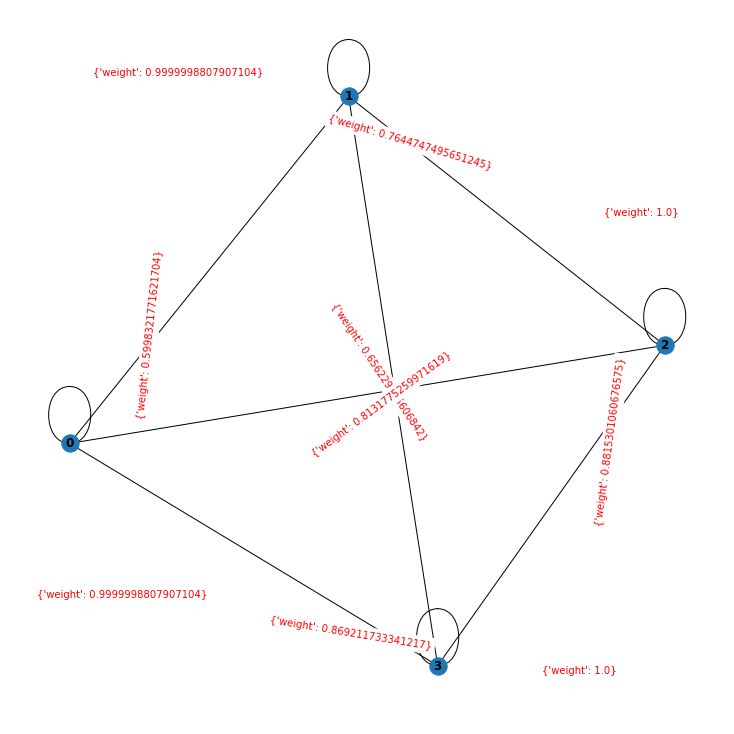

In [82]:
draw_graphs(data['SimMatrix'][1])

In [84]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [85]:
score = calculate_score(data['SimMatrix'][0])

In [86]:
data['score'] = data['SimMatrix'].apply(calculate_score)

In [87]:
data['score'][1]

{0: 0.23282257782526034,
 1: 0.2492208381855153,
 2: 0.26070905096436847,
 3: 0.25724753302485603}

In [88]:
def ranked_sentences(sentences, scores, n=1):
    top_scores = sorted(((scores[i],s) 
                         for i,s in enumerate(sentences)), 
                                reverse=True)
    top_n_sentences = [sentence 
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

In [89]:
data['summary'] = data.apply(lambda x: 
                            ranked_sentences(x.sent, 
                            x.score), axis=1)

In [90]:
cnt = 0
for i in range(0, len(data)):
    label = data.loc[i].labels.index(1)
    
    if data.loc[i].sent[label] == data.loc[i].summary:
        cnt += 1
        print(cnt)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


# AE

In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [2]:
with open("./data/train.json") as f:
    examples = [json.loads(line) for line in f]

In [3]:
train_df = pd.DataFrame(columns=["doc", "sent"])

In [4]:
count = 0

for n, ex in enumerate(examples[:100]):
    sents = ex['doc'].split('\n')
    
    tmp = list()
    tmp.append(ex['doc'])
    tmp.append(sents)

    train_df.loc[count] = tmp
    count += 1
    

In [5]:
import json
from models.encoder import Encoder
import utils
import argparse,random,logging,numpy,os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm
from time import time
from tqdm import tqdm
from util import load_dataset, make_iter, Params

In [6]:
params = Params('config/params.json')

embed = torch.Tensor(np.load("./data/embedding.npz")['embedding'])
with open("./data/word2id.json") as f:
    word2id = json.load(f)
vocab = utils.Vocab(embed, word2id)


In [7]:
"""
ae
"""
# load
pretrained_dict = torch.load("./entire_ae.pt")
model = Encoder(params)
model_dict = model.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# 3. load the new state dict
model.load_state_dict(model_dict)

model.to(params.device)
model.eval()

Encoder(
  (token_embedding): Embedding(153824, 512, padding_idx=1)
  (pos_embedding): Embedding(1025, 512)
  (encoder_layers): ModuleList(
    (0): EncoderLayer(
      (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiHeadAttention(
        (attentions): ModuleList(
          (0): SelfAttention(
            (q_w): Linear(in_features=512, out_features=64, bias=False)
            (k_w): Linear(in_features=512, out_features=64, bias=False)
            (v_w): Linear(in_features=512, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SelfAttention(
            (q_w): Linear(in_features=512, out_features=64, bias=False)
            (k_w): Linear(in_features=512, out_features=64, bias=False)
            (v_w): Linear(in_features=512, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): SelfAttention(
            (q_w): Linear(in_feat

In [8]:
"""
ae embedding 만들기
"""
doc_num = len(examples)
time_cost = 0
file_id = 1
doc_trunc=100
sent_trunc=10
word_trunc=20
PAD_TOKEN = '<pad>'
PAD_IDX = 0
UNK_TOKEN = '<unk>'
UNK_IDX = 1

def w2i(w):
    if w in word2id:
        return word2id[w]
    else:
        return UNK_IDX

ae_output = list()
for i, sents in enumerate(train_df['sent']):
    input_list,doc_lens = [],[]

    max_sent_num = sent_trunc
    sents = sents[:max_sent_num]
    doc_lens.append(len(sents))

    """
    doc
    """
    # trunc or pad sent
    max_sent_len = 0
    batch_sents = []
    for sent in sents:
        words = sent.split()
        if len(words) > word_trunc:
            words = words[:word_trunc]
        max_sent_len = len(words) if len(words) > max_sent_len else max_sent_len
        batch_sents.append(words)

    #train_df.loc[count] = tmp
    
    features = []
    for sent in batch_sents:
        feature = [w2i(w) for w in sent] + [PAD_IDX for _ in range(word_trunc-len(sent))]
        features.append(feature)

    # 문장 패딩
    padded_features = []
    padlist = [0 for _ in range(word_trunc)]

    if sent_trunc - len(features) > 0:
        for _ in range(sent_trunc - len(features)):
            features.append(padlist)

    features = torch.LongTensor(features) 
    features=Variable(features)

    encoder_output = model(features)

    tmp = list()
    for output in encoder_output:
        result = np.array(output.mean(dim=1).tolist())
        
        result = np.nan_to_num(result)
        tmp.append(result)

    ae_output.append(tmp)



In [16]:
scaled_output = list()
for x in ae_output:
    tmp = list()
    for X in x:
        tmp.append(np.array((X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))))
    scaled_output.append(tmp)

<ipython-input-16-09832ac0c2d6>:5: RuntimeWarning: invalid value encountered in true_divide
  tmp.append(np.array((X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))))


In [15]:
for x in ae_output:
    print(x)

[array([ 5.12227416e-09, -2.93366611e-08, -2.32830644e-08,  2.32830644e-08,
       -1.00117177e-08, -1.35041773e-08,  1.58324838e-08,  4.65661287e-09,
        1.30385160e-08, -2.98023224e-08, -1.58324838e-08,  9.31322575e-10,
       -1.97906047e-08, -3.72529030e-09, -1.02445483e-08, -2.04890966e-08,
        2.70083547e-08, -5.12227416e-09,  8.38190317e-09, -5.58793545e-09]), array([-1.86264515e-08, -6.98491931e-09, -6.05359674e-09,  9.31322575e-09,
       -2.79396772e-09,  1.49011612e-08, -7.45058060e-09,  1.30385160e-08,
       -7.45058060e-09,  1.86264515e-09, -1.95577741e-08, -6.51925802e-09,
        8.38190317e-09,  5.58793545e-09,  1.49011612e-08,  8.38190317e-09,
        2.79396772e-09,  0.00000000e+00,  2.79396772e-08,  5.12227416e-09]), array([ 7.45058060e-09,  1.39698386e-09,  2.79396772e-09,  3.25962901e-09,
        7.45058060e-09,  1.90921128e-08, -1.25728548e-08,  0.00000000e+00,
       -9.54605639e-09, -6.28642738e-09,  1.11758709e-08, -6.75208867e-09,
       -1.25728548e-

        7.45058060e-09, -5.58793545e-09,  6.98491931e-09, -4.65661287e-09])]
[array([ 1.39698386e-08, -3.02679837e-08, -1.90921128e-08,  2.65426934e-08,
       -1.86264515e-09,  2.09547579e-09, -1.28056854e-08, -4.65661287e-09,
       -2.84053385e-08,  2.42143869e-08,  1.49011612e-08,  1.49011612e-08,
        1.49011612e-08,  1.49011612e-08,  1.49011612e-08,  1.49011612e-08,
        1.49011612e-08,  1.49011612e-08,  7.45058060e-09,  7.45058060e-09]), array([-7.45058060e-09, -1.25728548e-08,  1.58324838e-08,  1.02445483e-08,
       -6.51925802e-09,  4.65661287e-09, -1.86264515e-09,  5.58793545e-09,
        1.67638063e-08, -9.31322575e-09, -4.65661287e-09,  2.72411853e-08,
        9.77888703e-09,  1.86264515e-09, -1.39698386e-08, -4.65661287e-10,
       -2.79396772e-09,  9.31322575e-10, -2.32830644e-08, -4.65661287e-10]), array([ 2.32830644e-09,  2.04890966e-08,  3.72529030e-08, -2.79396772e-08,
        1.58324838e-08,  1.86264515e-08,  1.86264515e-08,  6.51925802e-09,
        7.45058060

In [12]:
train_df['SentenceEmbedding'] = scaled_output

In [14]:
embedding_dim = 20
zero_vector = np.zeros(20)

def similarity_matrix(sentence_embedding):
    sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
    for i in range(len(sentence_embedding)):
        for j in range(len(sentence_embedding)):
            sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, 20),
                                          sentence_embedding[j].reshape(1, 20))[0,0]
    return sim_mat

train_df['SimMatrix'] = train_df['SentenceEmbedding'].apply(similarity_matrix)
train_df['SimMatrix']

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [125]:
train_df

,doc,sent,SentenceEmbedding,SimMatrix
0,by daily mail reporter last updated at 11:49 a...,[by daily mail reporter last updated at 11:49 ...,"[[7.450580596923828e-09, -2.60770320892334e-08...","[[1.0000000000000002, 0.2230585179641465, 0.22..."
1,with the trademark curly hair and giant person...,[with the trademark curly hair and giant perso...,"[[-7.450580596923828e-09, 0.0, -1.862645149230...","[[1.0000000000000002, 0.03711146753158796, 0.1..."
2,by thomas durante a newly - released surveilla...,[by thomas durante a newly - released surveill...,"[[2.0489096641540527e-08, -9.313225746154785e-...","[[0.9999999999999997, 0.278265873946936, -0.13..."
3,by associated press reporter published : 15:09...,[by associated press reporter published : 15:0...,"[[1.1175870895385742e-08, 2.0489096641540527e-...","[[1.0, 0.22135435362177788, 0.0900133276056258..."
4,employment minister esther mcvey has laughed o...,[employment minister esther mcvey has laughed ...,"[[2.7939677238464355e-08, -1.4901161193847656e...","[[1.0000000000000002, -0.071688768601392, 0.27..."
...,...,...,...,...
95,some of uk 's hottest acting talent has come t...,[some of uk 's hottest acting talent has come ...,"[[-2.2351741790771484e-08, -1.862645149230957e...","[[1.0, -0.3597062308593991, 0.3856537956026731..."
96,by richard shears last updated at 2:26 pm on 2...,[by richard shears last updated at 2:26 pm on ...,"[[1.4901161193847656e-08, -3.725290298461914e-...","[[1.0, 0.3624975104177821, 0.2357359878713176,..."
97,by rob waugh our ancestor ? the remains of two...,[by rob waugh our ancestor ? the remains of tw...,"[[-1.862645149230957e-08, -3.725290298461914e-...","[[1.0000000000000002, -0.2022332341086491, -0...."
98,gamblers at skycity casino on saturday night k...,[gamblers at skycity casino on saturday night ...,"[[-7.450580596923828e-09, -7.450580596923828e-...","[[1.0, -0.037564805332731696, 0.09673284010733..."


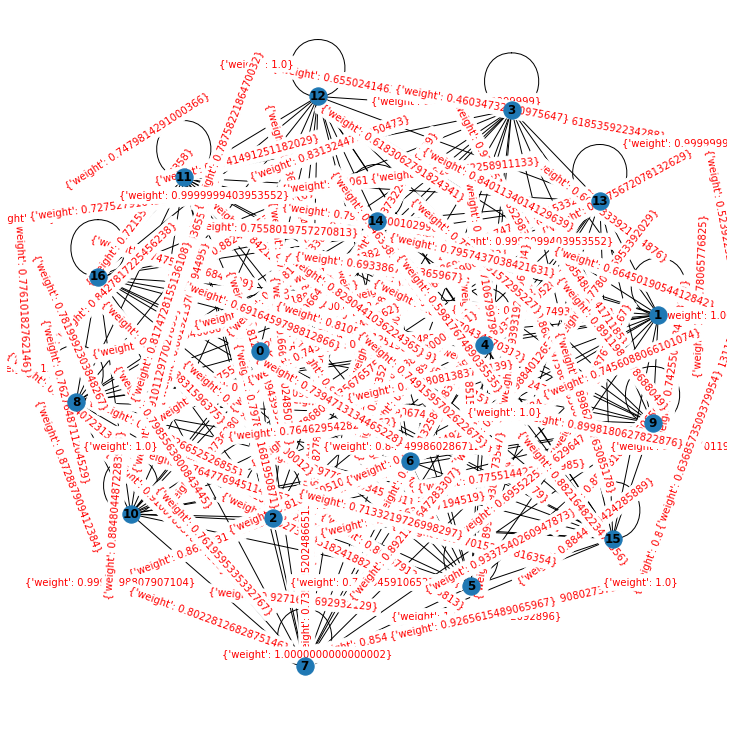

In [126]:
def draw_graphs(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()

draw_graphs(data['SimMatrix'][2])

In [129]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    print(nx_graph)
    scores = nx.pagerank(nx_graph, max_iter=10000000000)
    return scores

In [142]:
train_df['SimMatrix'][0]

array([[ 1.        ,  0.22305852,  0.22809248, -0.09307969, -0.30831422,
         0.34760687,  0.26417012, -0.0898021 ,  0.22221139,  0.35571201],
       [ 0.22305852,  1.        ,  0.02489569,  0.13734856, -0.01963874,
         0.27908711,  0.1968529 ,  0.09336083,  0.08641239,  0.54108802],
       [ 0.22809248,  0.02489569,  1.        , -0.06696648,  0.09527064,
         0.18874825,  0.17521478,  0.05109734,  0.1206299 ,  0.29018722],
       [-0.09307969,  0.13734856, -0.06696648,  1.        , -0.05005756,
        -0.11005578, -0.19589834,  0.34528368, -0.25853163,  0.25677525],
       [-0.30831422, -0.01963874,  0.09527064, -0.05005756,  1.        ,
        -0.2955823 , -0.07908038, -0.15623751, -0.09505558,  0.03263071],
       [ 0.34760687,  0.27908711,  0.18874825, -0.11005578, -0.2955823 ,
         1.        ,  0.37297399, -0.07212532,  0.0283882 , -0.10454161],
       [ 0.26417012,  0.1968529 ,  0.17521478, -0.19589834, -0.07908038,
         0.37297399,  1.        , -0.00137108

In [141]:
scores = calculate_score(train_df['SimMatrix'][0])

Graph with 10 nodes and 55 edges


/Users/hbae/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


KeyboardInterrupt: 

In [56]:
def ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s) 
                         for i,s in enumerate(sentences)), 
                                reverse=True)
    top_n_sentences = [sentence 
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

In [59]:
train_df['summary'] = train_df.apply(lambda x: 
                            ranked_sentences(x.sent, 
                            x.score), axis=1)

AttributeError: 'Series' object has no attribute 'score'